In [1]:
import pandas as pd

# Load the CSV data into a DataFrame
jokes_df = pd.read_csv('jokes_dataset.csv')

# print the first 5 rows of the DataFrame
print(jokes_df.head())


                                                text  humor
0  Joe biden rules out 2020 bid: 'guys, i'm not r...  False
1  Watch: darvish gave hitter whiplash with slow ...  False
2  What do you call a turtle without its shell? d...   True
3      5 reasons the 2016 election feels so personal  False
4  Pasco police shot mexican migrant from behind,...  False


In [2]:
import nltk
from nltk.corpus import stopwords
import string
import re

# Download the stopwords corpus
nltk.download('stopwords')

# Define a function to preprocess the jokes
def preprocess_jokes(jokes_df):
    # Remove stopwords and punctuation
    stop_words = set(stopwords.words('english'))
    jokes_df['clean_joke'] = jokes_df['text'].apply(lambda x: ' '.join([word.lower() for word in x.split() if (word.lower() not in stop_words) and (word.lower() not in string.punctuation)]))
    return jokes_df

# Define a function to remove punctuation
def remove_punctuation(text):
    # Define the regular expression pattern to match any punctuation character
    pattern = r'[^\w\s]'

    # Use the sub() function to replace any matches with an empty string
    cleaned_text = re.sub(pattern, '', text)
    return cleaned_text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:

# Preprocess the jokes
preprocess_jokes(jokes_df)

# Apply the remove_punctuation function to the Clean_joke column
jokes_df['clean_joke'] = jokes_df['clean_joke'].apply(remove_punctuation)


Model #1: Simple logistic regression model using TFIDF vectorization.



In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(jokes_df['clean_joke'], jokes_df['humor'], test_size=0.2, random_state=42)

# Define the pipeline
pipe = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression())
])

# Train the model using the pipeline
pipe.fit(X_train, y_train)

# Predict on training data
y_train_pred = pipe.predict(X_train)

# Calculate accuracy score on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

# Predict on test data
y_pred = pipe.predict(X_test)

# Calculate accuracy score on test data
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)


Training Accuracy: 0.92921875
Test Accuracy: 0.9108


In [6]:
from sklearn.metrics import classification_report

# get classification report
report = classification_report(y_test, y_pred)
print(report)


              precision    recall  f1-score   support

       False       0.91      0.91      0.91     20001
        True       0.91      0.91      0.91     19999

    accuracy                           0.91     40000
   macro avg       0.91      0.91      0.91     40000
weighted avg       0.91      0.91      0.91     40000



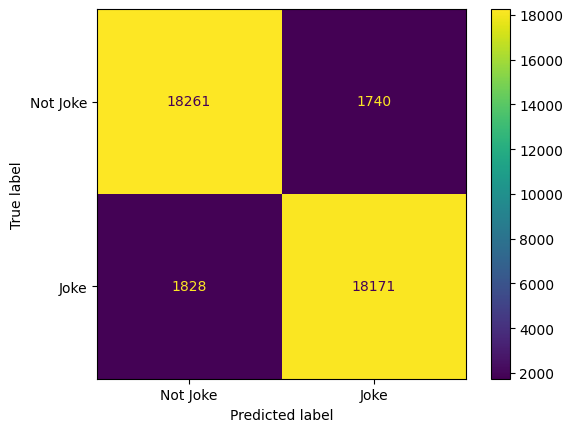

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# assume y_true and y_pred are already defined
y_pred_binary = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred_binary)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Joke", "Joke"])
disp.plot()


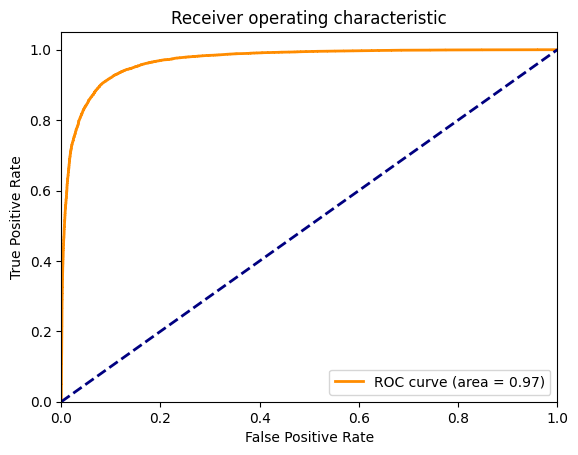

In [9]:
# Get the predicted probabilities for the positive class
y_proba = pipe.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Model #2: Logistic regression with lemmatization to test if lemmatization will help accuracy.

In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import nltk
from nltk.stem import WordNetLemmatizer

# Download NLTK data
nltk.download('punkt')
nltk.download('wordnet')

# Initialize the WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

# Define a function to lemmatize a list of documents
def lemmatize_docs(docs):
    lemmatized_docs = []
    for doc in docs:
        tokens = nltk.word_tokenize(doc)
        lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
        lemmatized_docs.append(' '.join(lemmatized_tokens))
    return lemmatized_docs


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(jokes_df['clean_joke'], jokes_df['humor'], test_size=0.2, random_state=42)

# Define the pipeline
pipe = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', LogisticRegression())
])

# Train the model using the pipeline
pipe.fit(lemmatize_docs(X_train), y_train)

# Predict on training data
y_train_pred = pipe.predict(lemmatize_docs(X_train))

# Calculate accuracy score on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

# Predict on test data
y_pred = pipe.predict(lemmatize_docs(X_test))

# Calculate accuracy score on test data
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Training Accuracy: 0.92335625
Test Accuracy: 0.905625


In [11]:
from sklearn.metrics import classification_report

# get classification report
report = classification_report(y_test, y_pred)
print(report)


              precision    recall  f1-score   support

       False       0.90      0.91      0.91     20001
        True       0.91      0.90      0.91     19999

    accuracy                           0.91     40000
   macro avg       0.91      0.91      0.91     40000
weighted avg       0.91      0.91      0.91     40000



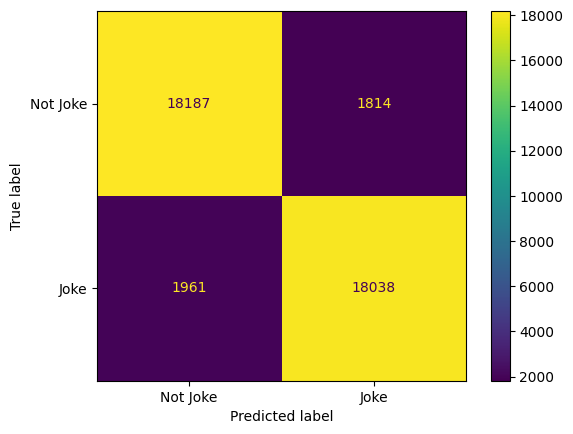

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# assume y_true and y_pred are already defined
y_pred_binary = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y_test, y_pred_binary)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Joke", "Joke"])
disp.plot()


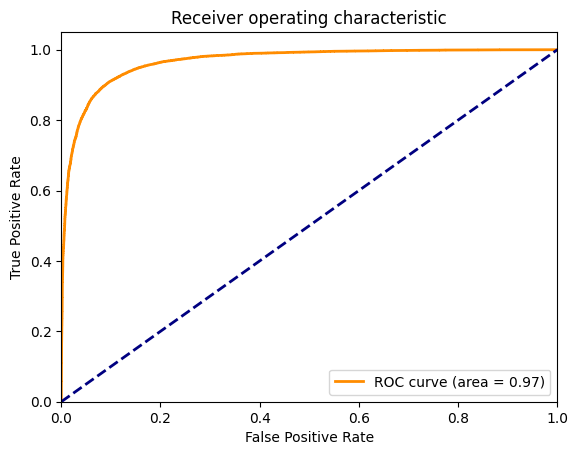

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Predict probabilities for test set
y_pred_proba = pipe.predict_proba(lemmatize_docs(X_test))[:, 1]

# Calculate false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


Model #3: Support Vector Machines (SVM) model.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import nltk
from nltk.stem import WordNetLemmatizer

# Download NLTK data
nltk.download('punkt')
nltk.download('wordnet')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(jokes_df['clean_joke'], jokes_df['humor'], test_size=0.2, random_state=42)

# Define the pipeline with probability=True in SVC
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('svc', SVC(C=1, kernel='linear', probability=True))
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Make predictions on the training data
y_train_pred = pipeline.predict(X_train)

# Evaluate the model's accuracy on the training data
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Train Accuracy:", train_accuracy)

# Make predictions on the test data
y_pred = pipeline.predict(X_test)

# Evaluate the model's accuracy on the test data
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [15]:
from sklearn.metrics import classification_report

# get classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

       False       0.92      0.91      0.91     20001
        True       0.91      0.92      0.91     19999

    accuracy                           0.91     40000
   macro avg       0.91      0.91      0.91     40000
weighted avg       0.91      0.91      0.91     40000



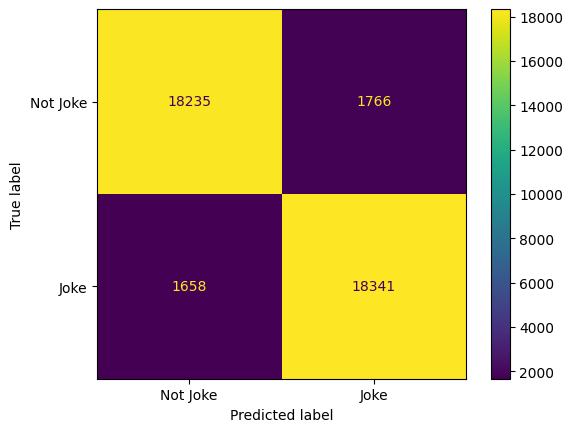

In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Joke", "Joke"])
disp.plot()

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Get predicted probabilities for the test data
y_prob = pipeline.predict_proba(X_test)[:, 1]

# Calculate false positive rate, true positive rate, and thresholds for ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate AUC score
auc_score = roc_auc_score(y_test, y_prob)

# Plot ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (AUC = {:.2f})'.format(auc_score))
plt.show()


AttributeError: ignored

Model #4: RandomForest 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
X = jokes_df[['clean_joke']]
y = jokes_df['humor']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data using TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train.squeeze())
X_test_vec = vectorizer.transform(X_test.squeeze())

# Train a Random Forest Classifier model
clf = RandomForestClassifier()
clf.fit(X_train_vec, y_train)

# Predict on training data
y_train_pred = clf.predict(X_train_vec)

# Calculate accuracy score on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

# Predict on test data
y_pred = clf.predict(X_test_vec)

# Calculate accuracy score on test data
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)


Training Accuracy: 0.9999875
Test Accuracy: 0.885425


Grid search for finding optimal parameters for RF model.

In [ ]:
# take a random sample of 500 rows
jokes_sampled = jokes_df.sample(n=20000, random_state=42)

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
X = jokes_sampled[['clean_joke']]
y = jokes_sampled['humor']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data using TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train.squeeze())
X_test_vec = vectorizer.transform(X_test.squeeze())

# Define the parameter grid to search
param_grid = {
    'max_depth': [10, 50, 100],
    'min_samples_leaf': [1, 5, 10]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_vec, y_train)

# Print the best parameters and accuracy score
print("Best Parameters:", grid_search.best_params_)
print("Training Accuracy:", grid_search.best_score_)

# Predict on test data using best estimator
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test_vec)

# Calculate accuracy score on test data
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)


Best Parameters: {'max_depth': 100, 'min_samples_leaf': 1}
Training Accuracy: 0.8249375000000001
Test Accuracy: 0.819


Final RF model using optimal parameters.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
X = jokes_df[['clean_joke']]
y = jokes_df['humor']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data using TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train.squeeze())
X_test_vec = vectorizer.transform(X_test.squeeze())

# Set optimal parameters
optimal_params = {'max_depth': 100, 'min_samples_leaf': 1}

# Initialize a random forest classifier with optimal parameters
clf = RandomForestClassifier(**optimal_params)

# Fit the classifier to the training data
clf.fit(X_train_vec, y_train)

# Predict on the training and test data
y_train_pred = clf.predict(X_train_vec)
y_test_pred = clf.predict(X_test_vec)

# Calculate accuracy score on the training and test data
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Print the accuracies
print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)


Training Accuracy: 0.897475
Test Accuracy: 0.85495


In [ ]:
from sklearn.metrics import classification_report

# get classification report
report = classification_report(y_test_pred, y_test)
print(report)

              precision    recall  f1-score   support

       False       0.88      0.84      0.86     21079
        True       0.83      0.88      0.85     18921

    accuracy                           0.85     40000
   macro avg       0.85      0.86      0.85     40000
weighted avg       0.86      0.85      0.86     40000



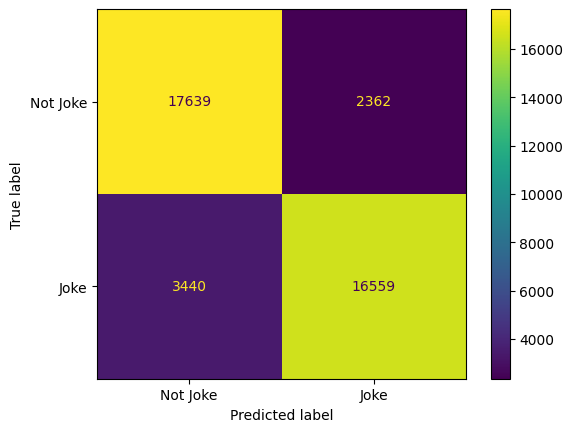

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Joke", "Joke"])
disp.plot()

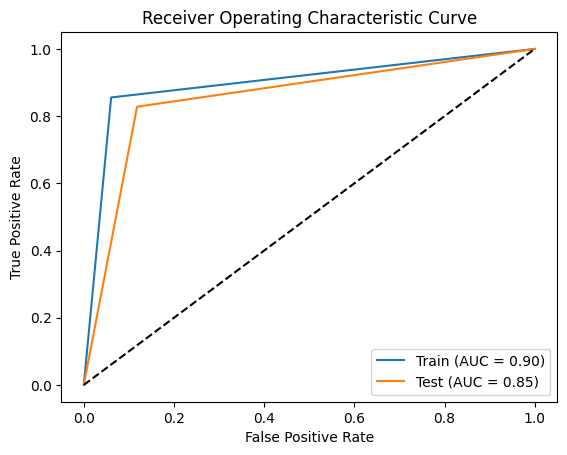

In [ ]:
# Plot ROC curve
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
auc_train = auc(fpr_train, tpr_train)
auc_test = auc(fpr_test, tpr_test)

plt.plot(fpr_train, tpr_train, label='Train (AUC = {:.2f})'.format(auc_train))
plt.plot(fpr_test, tpr_test, label='Test (AUC = {:.2f})'.format(auc_test))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc='lower right')
plt.show()

Model #5: K nearest neighbors

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# take a random sample of 500 rows
jokes_sampled = jokes_df.sample(n=30000, random_state=42)


# Split the data into training and testing sets
X = jokes_sampled[['clean_joke']]
y = jokes_sampled['humor']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data using TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train.squeeze())
X_test_vec = vectorizer.transform(X_test.squeeze())

# Define a range of hyperparameters to try
param_grid = {'n_neighbors': [3, 5, 7],
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'cosine']}

# Create a GridSearchCV object
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train_vec, y_train)

# Print the best hyperparameters and the corresponding mean cross-validated score
print("Best hyperparameters:", grid_search.best_params_)
print("Cross-validation score:", grid_search.best_score_)

# Train a KNN classifier model with the best hyperparameters found by grid search
clf = KNeighborsClassifier(n_neighbors=grid_search.best_params_['n_neighbors'], 
                           weights=grid_search.best_params_['weights'], 
                           metric=grid_search.best_params_['metric'])
clf.fit(X_train_vec, y_train)

# Predict on training data
y_train_pred = clf.predict(X_train_vec)

# Calculate accuracy score on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

# Predict on test data
y_pred = clf.predict(X_test_vec)

# Calculate accuracy score on test data
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)


Best hyperparameters: {'metric': 'cosine', 'n_neighbors': 7, 'weights': 'distance'}
Cross-validation score: 0.8187083333333334
Training Accuracy: 1.0
Test Accuracy: 0.824


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Split the data into training and testing sets
X = jokes_df['clean_joke']
y = jokes_df['humor']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data using TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Create the GradientBoostingClassifier object
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=4, min_samples_split=5)

# Fit the classifier to the training data
clf.fit(X_train_vec, y_train)

# Predict on training data
y_train_pred = clf.predict(X_train_vec)

# Predict on test data
y_test_pred = clf.predict(X_test_vec)

# Calculate accuracy score on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

# Calculate accuracy score on test data
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)


Training Accuracy: 0.774475
Test Accuracy: 0.7726


Model #6: XGBoost classification model

In [ ]:

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# take a random sample of 500 rows
jokes_sampled = jokes_df.sample(n=30000, random_state=42)


# Split the data into training and testing sets
X = jokes_sampled[['clean_joke']]
y = jokes_sampled['humor']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data using TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train.squeeze())
X_test_vec = vectorizer.transform(X_test.squeeze())

# Define the parameter grid for the grid search
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.1, 0.01]
}

# Train an XGBoost classifier model with grid search for hyperparameter tuning
clf = XGBClassifier()
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_vec, y_train)

# Print the best parameters and best score from the grid search
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Predict on training data with the best model from grid search
y_train_pred = grid_search.best_estimator_.predict(X_train_vec)

# Calculate accuracy score on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

# Predict on test data with the best model from grid search
y_pred = grid_search.best_estimator_.predict(X_test_vec)

# Calculate accuracy score on test data
test_accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", test_accuracy)


Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}
Best Score: 0.7726666666666666
Training Accuracy: 0.789875
Test Accuracy: 0.7675


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import StackingClassifier

# Split the data into training and testing sets
X = jokes_sampled[['clean_joke']]
y = jokes_sampled['humor']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the text data using TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train.squeeze())
X_test_vec = vectorizer.transform(X_test.squeeze())

# Create the base models
logreg = LogisticRegression()
rf = RandomForestClassifier()
svm = SVC(probability=True)

# Create the stacking model
estimators = [('logistic', logreg),
              ('rf', rf),
              ('svm', svm)]

stacking_model = StackingClassifier(estimators=estimators,
                                    final_estimator=LogisticRegression())

# Train the stacking model
stacking_model.fit(X_train_vec, y_train)

# Predict on the test data
y_pred = stacking_model.predict(X_test_vec)


In [ ]:
from sklearn.metrics import accuracy_score

# Calculate the train and test accuracy
train_acc = accuracy_score(y_train, stacking_model.predict(X_train_vec))
test_acc = accuracy_score(y_test, y_pred)

# Print the train and test accuracy
print('Train accuracy:', train_acc)
print('Test accuracy:', test_acc)


Train accuracy: 0.9869166666666667
Test accuracy: 0.8841666666666667


Will now iterate multiple neural network models.

Model #7: 

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
import numpy as np

# take a random sample of 500 rows
jokes_sampled = jokes_df.sample(n=20000, random_state=42)

# Split the data into training and testing sets
X = jokes_sampled[['clean_joke']]
y = jokes_sampled['humor']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to numpy arrays
X_train = X_train.to_numpy().squeeze()
X_test = X_test.to_numpy().squeeze()

# vectorize the text data using TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Define batch size and number of epochs
batch_size = 16
epochs = 10

# Build the neural network model
input_dim = X_train_vec.shape[1]
model = Sequential()
model.add(Dense(64, input_shape=(input_dim,), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_vec.toarray(), y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test_vec.toarray(), y_test))


Epoch 1/10
1000/1000 [==============================] - 25s 24ms/step - loss: 0.3738 - accuracy: 0.8333 - val_loss: 0.2953 - val_accuracy: 0.8752
Epoch 2/10
1000/1000 [==============================] - 23s 23ms/step - loss: 0.1294 - accuracy: 0.9540 - val_loss: 0.3467 - val_accuracy: 0.8737
Epoch 3/10
1000/1000 [==============================] - 21s 21ms/step - loss: 0.0505 - accuracy: 0.9834 - val_loss: 0.4523 - val_accuracy: 0.8675
Epoch 4/10
1000/1000 [==============================] - 22s 22ms/step - loss: 0.0188 - accuracy: 0.9942 - val_loss: 0.5553 - val_accuracy: 0.8640
Epoch 5/10
1000/1000 [==============================] - 22s 22ms/step - loss: 0.0069 - accuracy: 0.9982 - val_loss: 0.6822 - val_accuracy: 0.8660
Epoch 6/10
1000/1000 [==============================] - 31s 31ms/step - loss: 0.0029 - accuracy: 0.9993 - val_loss: 0.7860 - val_accuracy: 0.8627
Epoch 7/10
1000/1000 [==============================] - 23s 23ms/step - loss: 0.0013 - accuracy: 0.9997 - val_loss: 0.8997 -

In [ ]:
# Predict on test data
y_pred_prob = model.predict(X_test_vec.toarray())
y_pred = (y_pred_prob > 0.5).astype(int)


125/125 [==============================] - 1s 9ms/step


In [ ]:
train_loss, train_accuracy = model.evaluate(X_train_vec.toarray(), y_train)
test_loss, test_accuracy = model.evaluate(X_test_vec.toarray(), y_test)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


125/125 [==============================] - 1s 7ms/step - loss: 1.1423 - accuracy: 0.8658
Train Loss: 0.00016202959523070604
Train Accuracy: 0.9999374747276306
Test Loss: 1.142337679862976
Test Accuracy: 0.8657500147819519


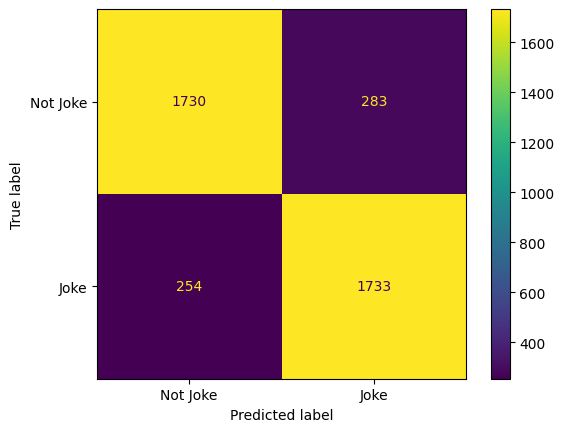

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Joke", "Joke"])
disp.plot()


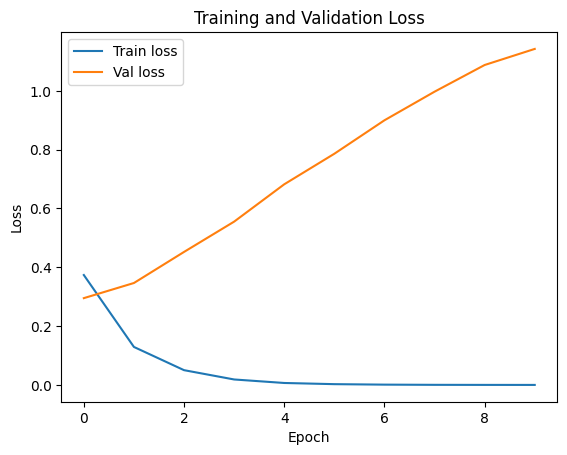

In [ ]:
# Plot training and validation loss history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [ ]:
from sklearn.metrics import classification_report

# get classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

       False       0.87      0.86      0.87      2013
        True       0.86      0.87      0.87      1987

    accuracy                           0.87      4000
   macro avg       0.87      0.87      0.87      4000
weighted avg       0.87      0.87      0.87      4000



Overfitting, so will be adding L2 regularization to the model.

Model #8: Neural network with L2 regularization

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers
import numpy as np

# take a random sample of 500 rows
jokes_sampled = jokes_df.sample(n=20000, random_state=42)

# Split the data into training and testing sets
X = jokes_sampled[['clean_joke']]
y = jokes_sampled['humor']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to numpy arrays
X_train = X_train.to_numpy().squeeze()
X_test = X_test.to_numpy().squeeze()

# vectorize the text data using TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Define batch size and number of epochs
batch_size = 16
epochs = 10

# Build the neural network model
input_dim = X_train_vec.shape[1]
model = Sequential()
model.add(Dense(64, input_shape=(input_dim,), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_vec.toarray(), y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test_vec.toarray(), y_test))



Epoch 1/10
1000/1000 [==============================] - 33s 32ms/step - loss: 0.7771 - accuracy: 0.7359 - val_loss: 0.7368 - val_accuracy: 0.8315
Epoch 2/10
1000/1000 [==============================] - 39s 39ms/step - loss: 0.7425 - accuracy: 0.8284 - val_loss: 0.7334 - val_accuracy: 0.8315
Epoch 3/10
1000/1000 [==============================] - 25s 25ms/step - loss: 0.7173 - accuracy: 0.8406 - val_loss: 0.6985 - val_accuracy: 0.8503
Epoch 4/10
1000/1000 [==============================] - 26s 26ms/step - loss: 0.7021 - accuracy: 0.8411 - val_loss: 0.6853 - val_accuracy: 0.8533
Epoch 5/10
1000/1000 [==============================] - 26s 26ms/step - loss: 0.6828 - accuracy: 0.8468 - val_loss: 0.6852 - val_accuracy: 0.8482
Epoch 6/10
1000/1000 [==============================] - 25s 25ms/step - loss: 0.6726 - accuracy: 0.8521 - val_loss: 0.6714 - val_accuracy: 0.8518
Epoch 7/10
1000/1000 [==============================] - 24s 24ms/step - loss: 0.6561 - accuracy: 0.8576 - val_loss: 0.6613 -

In [ ]:
# Predict on test data
y_pred_prob = model.predict(X_test_vec.toarray())
y_pred = (y_pred_prob > 0.5).astype(int)


125/125 [==============================] - 1s 10ms/step


In [ ]:
train_loss, train_accuracy = model.evaluate(X_train_vec.toarray(), y_train)
test_loss, test_accuracy = model.evaluate(X_test_vec.toarray(), y_test)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


125/125 [==============================] - 1s 7ms/step - loss: 0.6572 - accuracy: 0.8440
Train Loss: 0.5716061592102051
Train Accuracy: 0.8952500224113464
Test Loss: 0.6572346091270447
Test Accuracy: 0.843999981880188


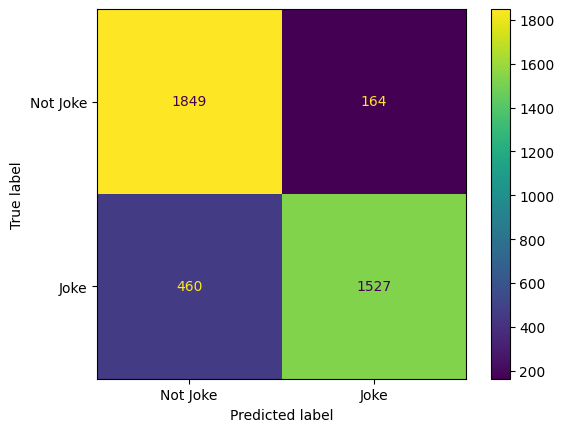

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Joke", "Joke"])
disp.plot()


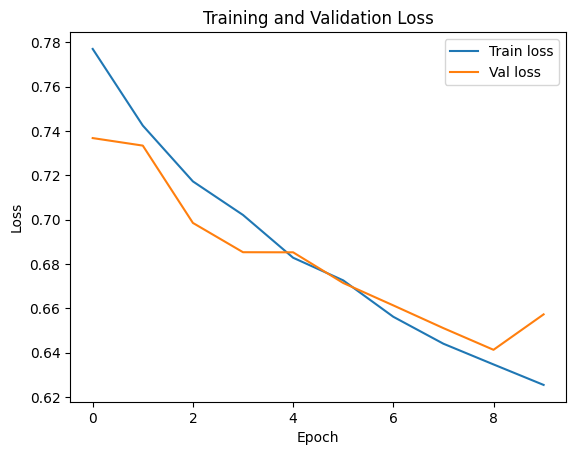

In [ ]:
# Plot training and validation loss history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


Updating architecture of model to try and improve accuracy. Try without L2 regularization and with increased dropout rate.

Model #9: Neural network with dropout

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
import numpy as np

# take a random sample of 20000 rows
jokes_sampled = jokes_df.sample(n=20000, random_state=42)

# Split the data into training and testing sets
X = jokes_sampled[['clean_joke']]
y = jokes_sampled['humor']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to numpy arrays
X_train = X_train.to_numpy().squeeze()
X_test = X_test.to_numpy().squeeze()

# vectorize the text data using TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Define batch size and number of epochs
batch_size = 16
epochs = 10

# Build the neural network model
input_dim = X_train_vec.shape[1]
model = Sequential()
model.add(Dense(64, input_shape=(input_dim,), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_vec.toarray(), y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test_vec.toarray(), y_test))


Epoch 1/10
1000/1000 [==============================] - 25s 23ms/step - loss: 0.4269 - accuracy: 0.8035 - val_loss: 0.2938 - val_accuracy: 0.8805
Epoch 2/10
1000/1000 [==============================] - 20s 20ms/step - loss: 0.1903 - accuracy: 0.9322 - val_loss: 0.3105 - val_accuracy: 0.8785
Epoch 3/10
1000/1000 [==============================] - 20s 20ms/step - loss: 0.1024 - accuracy: 0.9661 - val_loss: 0.3638 - val_accuracy: 0.8770
Epoch 4/10
1000/1000 [==============================] - 20s 20ms/step - loss: 0.0609 - accuracy: 0.9795 - val_loss: 0.4327 - val_accuracy: 0.8740
Epoch 5/10
1000/1000 [==============================] - 21s 21ms/step - loss: 0.0389 - accuracy: 0.9885 - val_loss: 0.5053 - val_accuracy: 0.8740
Epoch 6/10
1000/1000 [==============================] - 20s 20ms/step - loss: 0.0241 - accuracy: 0.9927 - val_loss: 0.5872 - val_accuracy: 0.8712
Epoch 7/10
1000/1000 [==============================] - 20s 20ms/step - loss: 0.0141 - accuracy: 0.9957 - val_loss: 0.6797 -

In [ ]:
# Predict on test data
y_pred_prob = model.predict(X_test_vec.toarray())
y_pred = (y_pred_prob > 0.5).astype(int)


125/125 [==============================] - 1s 6ms/step


In [ ]:
train_loss, train_accuracy = model.evaluate(X_train_vec.toarray(), y_train)
test_loss, test_accuracy = model.evaluate(X_test_vec.toarray(), y_test)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

125/125 [==============================] - 1s 6ms/step - loss: 0.8776 - accuracy: 0.8625
Train Loss: 0.0004075330216437578
Train Accuracy: 0.999875009059906
Test Loss: 0.8776341676712036
Test Accuracy: 0.862500011920929


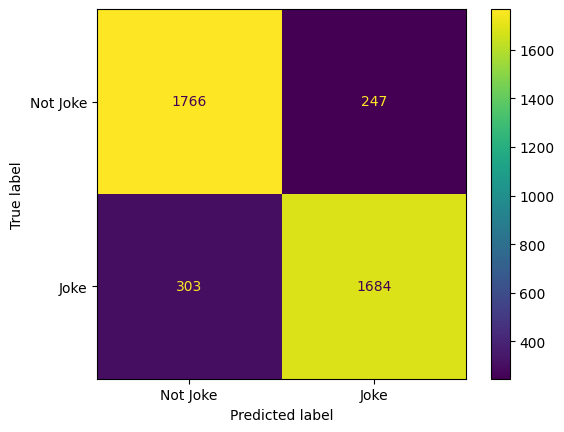

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Joke", "Joke"])
disp.plot()


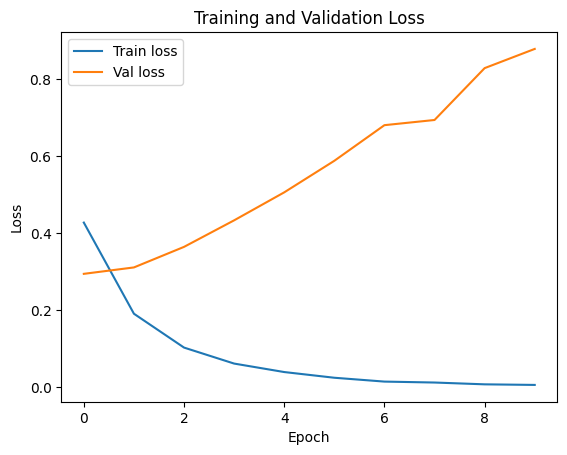

In [ ]:
# Plot training and validation loss history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Try 20% dropout with L2 regularization.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers
import numpy as np

# take a random sample of 500 rows
jokes_sampled = jokes_df.sample(n=20000, random_state=42)

# Split the data into training and testing sets
X = jokes_sampled[['clean_joke']]
y = jokes_sampled['humor']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to numpy arrays
X_train = X_train.to_numpy().squeeze()
X_test = X_test.to_numpy().squeeze()

# vectorize the text data using TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Define batch size and number of epochs
batch_size = 16
epochs = 10

# Build the neural network model with 20% dropout and L2 regularization
input_dim = X_train_vec.shape[1]
model = Sequential()
model.add(Dense(64, input_shape=(input_dim,), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_vec.toarray(), y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test_vec.toarray(), y_test))


Epoch 1/10
1000/1000 [==============================] - 24s 23ms/step - loss: 0.7724 - accuracy: 0.7225 - val_loss: 0.7413 - val_accuracy: 0.8310
Epoch 2/10
1000/1000 [==============================] - 22s 22ms/step - loss: 0.7446 - accuracy: 0.8276 - val_loss: 0.7477 - val_accuracy: 0.8070
Epoch 3/10
1000/1000 [==============================] - 21s 21ms/step - loss: 0.7227 - accuracy: 0.8351 - val_loss: 0.7049 - val_accuracy: 0.8378
Epoch 4/10
1000/1000 [==============================] - 21s 21ms/step - loss: 0.7026 - accuracy: 0.8399 - val_loss: 0.6946 - val_accuracy: 0.8457
Epoch 5/10
1000/1000 [==============================] - 22s 22ms/step - loss: 0.6873 - accuracy: 0.8457 - val_loss: 0.6782 - val_accuracy: 0.8510
Epoch 6/10
1000/1000 [==============================] - 21s 21ms/step - loss: 0.6749 - accuracy: 0.8504 - val_loss: 0.6714 - val_accuracy: 0.8480
Epoch 7/10
1000/1000 [==============================] - 21s 21ms/step - loss: 0.6660 - accuracy: 0.8509 - val_loss: 0.6596 -

In [ ]:
# Predict on test data
y_pred_prob = model.predict(X_test_vec.toarray())
y_pred = (y_pred_prob > 0.5).astype(int)


125/125 [==============================] - 1s 10ms/step


In [ ]:
train_loss, train_accuracy = model.evaluate(X_train_vec.toarray(), y_train)
test_loss, test_accuracy = model.evaluate(X_test_vec.toarray(), y_test)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

125/125 [==============================] - 2s 12ms/step - loss: 0.6282 - accuracy: 0.8625
Train Loss: 0.5408730506896973
Train Accuracy: 0.9169374704360962
Test Loss: 0.6281905770301819
Test Accuracy: 0.862500011920929


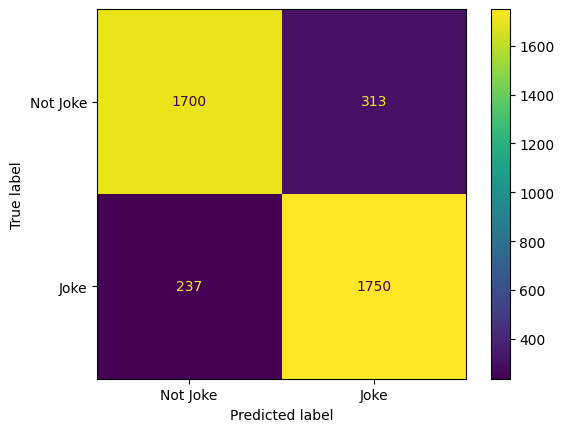

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Joke", "Joke"])
disp.plot()

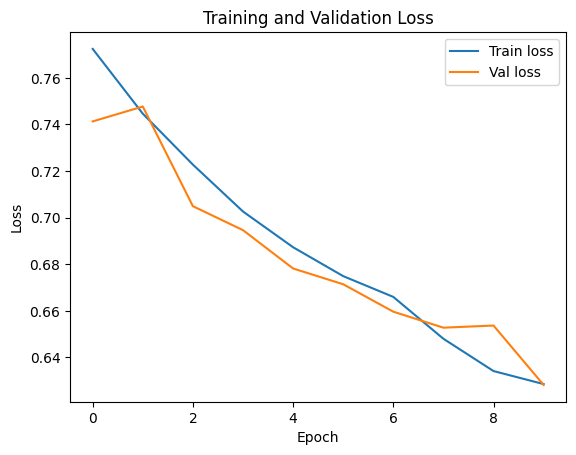

In [ ]:
# Plot training and validation loss history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from keras import regularizers
import numpy as np

# take a random sample of 500 rows
jokes_sampled = jokes_df.sample(n=20000, random_state=42)

# Split the data into training and testing sets
X = jokes_sampled[['clean_joke']]
y = jokes_sampled['humor']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to numpy arrays
X_train = X_train.to_numpy().squeeze()
X_test = X_test.to_numpy().squeeze()

# vectorize the text data using TF-IDF vectorizer
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Define batch size and number of epochs
batch_size = 16
epochs = 20

# Build the neural network model with 20% dropout and L2 regularization
input_dim = X_train_vec.shape[1]
model = Sequential()
model.add(Dense(64, input_shape=(input_dim,), activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Set up early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Train the model with early stopping
history = model.fit(X_train_vec.toarray(), y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test_vec.toarray(), y_test), callbacks=[early_stopping])



Epoch 1/20
1000/1000 [==============================] - 32s 29ms/step - loss: 0.7798 - accuracy: 0.7629 - val_loss: 0.7381 - val_accuracy: 0.8363
Epoch 2/20
1000/1000 [==============================] - 22s 22ms/step - loss: 0.7497 - accuracy: 0.8296 - val_loss: 0.7234 - val_accuracy: 0.8487
Epoch 3/20
1000/1000 [==============================] - 23s 23ms/step - loss: 0.7254 - accuracy: 0.8357 - val_loss: 0.7073 - val_accuracy: 0.8420
Epoch 4/20
1000/1000 [==============================] - 24s 24ms/step - loss: 0.7087 - accuracy: 0.8413 - val_loss: 0.7036 - val_accuracy: 0.8422
Epoch 5/20
1000/1000 [==============================] - 38s 38ms/step - loss: 0.6891 - accuracy: 0.8469 - val_loss: 0.6746 - val_accuracy: 0.8480
Epoch 6/20
1000/1000 [==============================] - 26s 26ms/step - loss: 0.6663 - accuracy: 0.8494 - val_loss: 0.6639 - val_accuracy: 0.8525
Epoch 7/20
1000/1000 [==============================] - 23s 23ms/step - loss: 0.6503 - accuracy: 0.8570 - val_loss: 0.6531 -

In [ ]:
# Predict on test data
y_pred_prob = model.predict(X_test_vec.toarray())
y_pred = (y_pred_prob > 0.5).astype(int)

125/125 [==============================] - 1s 8ms/step


In [ ]:
train_loss, train_accuracy = model.evaluate(X_train_vec.toarray(), y_train)
test_loss, test_accuracy = model.evaluate(X_test_vec.toarray(), y_test)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

125/125 [==============================] - 1s 6ms/step - loss: 0.6045 - accuracy: 0.8555
Train Loss: 0.47774749994277954
Train Accuracy: 0.9356250166893005
Test Loss: 0.6044592261314392
Test Accuracy: 0.8554999828338623


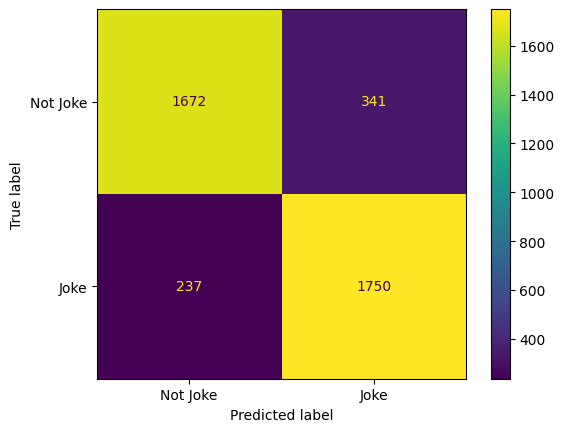

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Joke", "Joke"])
disp.plot()

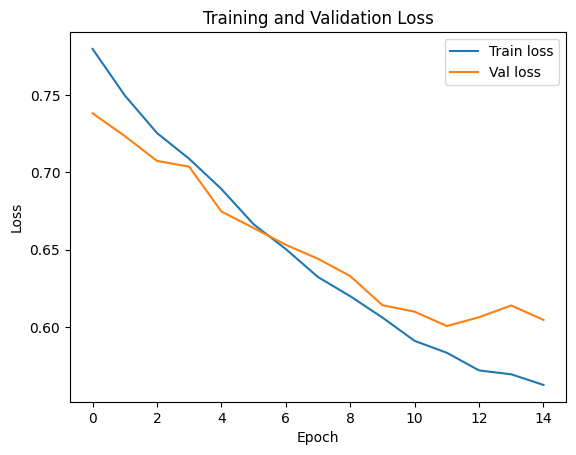

In [ ]:
# Plot training and validation loss history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Build CNN model for classification. Defines a CNN model with an Embedding layer, two Conv1D layers, a MaxPooling1D layer, a GlobalMaxPooling1D layer, two Dense layers, and a Dropout layer.

Model #10: CNN 

In [ ]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, Conv1D, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences



# take a random sample of 500 rows
jokes_sampled = jokes_df.sample(n=20000, random_state=42)

# Split the data into training and testing sets
X = jokes_sampled['clean_joke'].to_numpy()
y = jokes_sampled['humor']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize the text data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad the sequences to a fixed length
maxlen = 100
X_train_padded = pad_sequences(X_train_seq, maxlen=maxlen)
X_test_padded = pad_sequences(X_test_seq, maxlen=maxlen)

# Define batch size and number of epochs
batch_size = 16
epochs = 10

# Build the CNN model with 20% dropout and L2 regularization
input_dim = X_train_padded.shape[1]
model = Sequential()
model.add(Embedding(10000, 100, input_length=maxlen))
model.add(Conv1D(64, 5, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(GlobalMaxPooling1D())
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with early stopping
history = model.fit(X_train_padded, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test_padded, y_test))


Epoch 1/10
1000/1000 [==============================] - 27s 26ms/step - loss: 0.5181 - accuracy: 0.8092 - val_loss: 0.3479 - val_accuracy: 0.8805
Epoch 2/10
1000/1000 [==============================] - 27s 27ms/step - loss: 0.2486 - accuracy: 0.9311 - val_loss: 0.3434 - val_accuracy: 0.8795
Epoch 3/10
1000/1000 [==============================] - 26s 26ms/step - loss: 0.1688 - accuracy: 0.9617 - val_loss: 0.3785 - val_accuracy: 0.8705
Epoch 4/10
1000/1000 [==============================] - 26s 26ms/step - loss: 0.1222 - accuracy: 0.9789 - val_loss: 0.4216 - val_accuracy: 0.8665
Epoch 5/10
1000/1000 [==============================] - 27s 27ms/step - loss: 0.0913 - accuracy: 0.9877 - val_loss: 0.4616 - val_accuracy: 0.8648
Epoch 6/10
1000/1000 [==============================] - 26s 26ms/step - loss: 0.0726 - accuracy: 0.9933 - val_loss: 0.4921 - val_accuracy: 0.8550
Epoch 7/10
1000/1000 [==============================] - 25s 25ms/step - loss: 0.0584 - accuracy: 0.9956 - val_loss: 0.5308 -

In [ ]:
# Predict on test data
y_pred_prob = model.predict(X_test_padded)
y_pred = (y_pred_prob > 0.5).astype(int)

125/125 [==============================] - 1s 10ms/step


In [ ]:
train_loss, train_accuracy = model.evaluate(X_train_padded, y_train)
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

125/125 [==============================] - 1s 7ms/step - loss: 0.6027 - accuracy: 0.8543
Train Loss: 0.03270208090543747
Train Accuracy: 0.9991250038146973
Test Loss: 0.6027002930641174
Test Accuracy: 0.8542500138282776


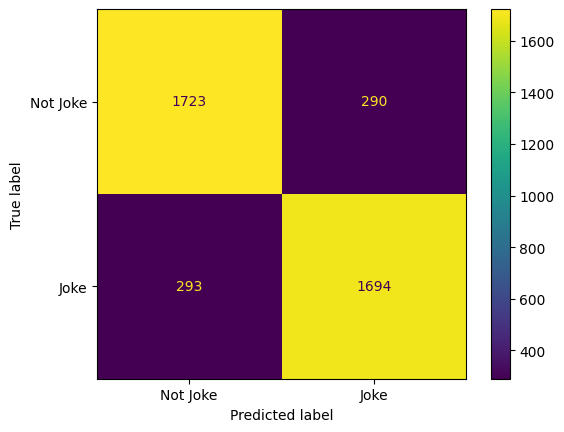

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Joke", "Joke"])
disp.plot()

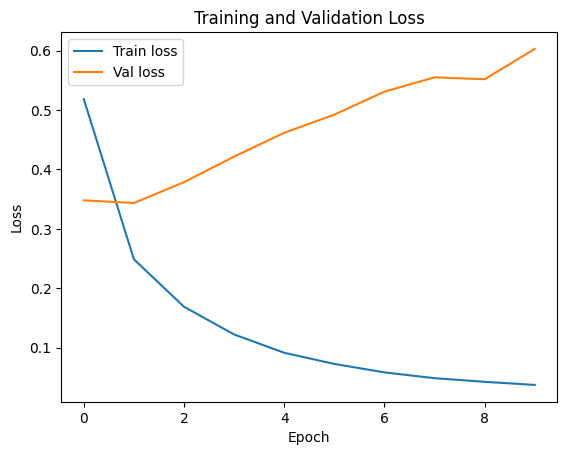

In [ ]:
# Plot training and validation loss history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Update regularization strength and dropout rate.

In [ ]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, Conv1D, GlobalMaxPooling1D
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences



# take a random sample of 500 rows
jokes_sampled = jokes_df.sample(n=20000, random_state=42)

# Split the data into training and testing sets
X = jokes_sampled['clean_joke'].to_numpy()
y = jokes_sampled['humor']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize the text data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad the sequences to a fixed length
maxlen = 100
X_train_padded = pad_sequences(X_train_seq, maxlen=maxlen)
X_test_padded = pad_sequences(X_test_seq, maxlen=maxlen)

# Define batch size and number of epochs
batch_size = 16
epochs = 10

# Build the CNN model with L2 regularization
input_dim = X_train_padded.shape[1]
l2_strength = 0.01
model = Sequential()
model.add(Embedding(10000, 100, input_length=maxlen))
model.add(Conv1D(64, 5, activation='relu', kernel_regularizer=regularizers.l2(l2_strength)))
model.add(GlobalMaxPooling1D())
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2_strength)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with early stopping
history = model.fit(X_train_padded, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test_padded, y_test))


Epoch 1/10
1000/1000 [==============================] - 42s 39ms/step - loss: 0.5597 - accuracy: 0.7958 - val_loss: 0.3625 - val_accuracy: 0.8767
Epoch 2/10
1000/1000 [==============================] - 31s 31ms/step - loss: 0.2813 - accuracy: 0.9231 - val_loss: 0.3594 - val_accuracy: 0.8675
Epoch 3/10
1000/1000 [==============================] - 31s 31ms/step - loss: 0.2011 - accuracy: 0.9545 - val_loss: 0.3855 - val_accuracy: 0.8710
Epoch 4/10
1000/1000 [==============================] - 29s 29ms/step - loss: 0.1525 - accuracy: 0.9720 - val_loss: 0.4168 - val_accuracy: 0.8643
Epoch 5/10
1000/1000 [==============================] - 30s 30ms/step - loss: 0.1193 - accuracy: 0.9829 - val_loss: 0.4556 - val_accuracy: 0.8635
Epoch 6/10
1000/1000 [==============================] - 31s 31ms/step - loss: 0.0962 - accuracy: 0.9890 - val_loss: 0.5146 - val_accuracy: 0.8645
Epoch 7/10
1000/1000 [==============================] - 30s 30ms/step - loss: 0.0838 - accuracy: 0.9912 - val_loss: 0.4912 -

In [ ]:
# Predict on test data
y_pred_prob = model.predict(X_test_padded)
y_pred = (y_pred_prob > 0.5).astype(int)

125/125 [==============================] - 2s 12ms/step


In [ ]:
train_loss, train_accuracy = model.evaluate(X_train_padded, y_train)
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

125/125 [==============================] - 1s 7ms/step - loss: 0.6027 - accuracy: 0.8543
Train Loss: 0.03270208090543747
Train Accuracy: 0.9991250038146973
Test Loss: 0.6027002930641174
Test Accuracy: 0.8542500138282776


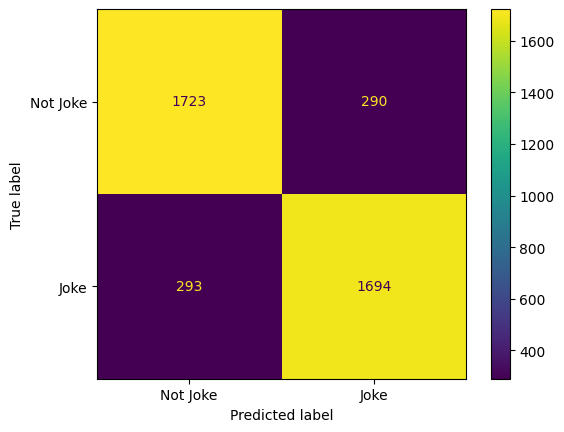

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Joke", "Joke"])
disp.plot()

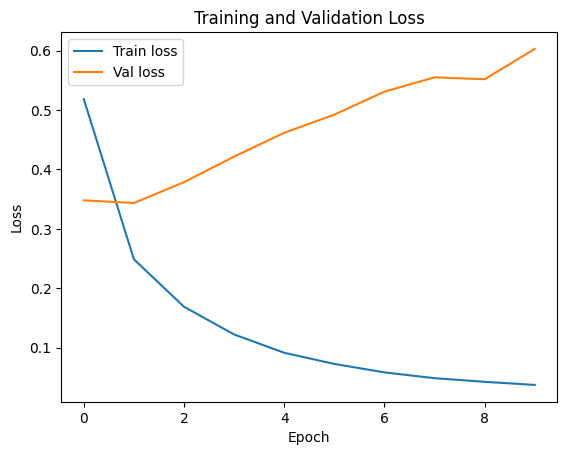

In [ ]:
# Plot training and validation loss history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Building a recurrent neural network (RNN) model for the same neural net archtiecture, replacing the Conv1D layer in the previous code with a recurrent layer LSTM.

Model #11: RNN 

In [ ]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# take a random sample of 500 rows
jokes_sampled = jokes_df.sample(n=20000, random_state=42)

# Split the data into training and testing sets
X = jokes_sampled['clean_joke'].to_numpy()
y = jokes_sampled['humor']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize the text data
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad the sequences to a fixed length
maxlen = 100
X_train_padded = pad_sequences(X_train_seq, maxlen=maxlen)
X_test_padded = pad_sequences(X_test_seq, maxlen=maxlen)

# Define batch size and number of epochs
batch_size = 16
epochs = 10

# Build the RNN model with L2 regularization
input_dim = X_train_padded.shape[1]
l2_strength = 0.01
model = Sequential()
model.add(Embedding(10000, 100, input_length=maxlen))
model.add(LSTM(64, kernel_regularizer=regularizers.l2(l2_strength)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with early stopping
history = model.fit(X_train_padded, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test_padded, y_test))


Epoch 1/10
1000/1000 [==============================] - 96s 92ms/step - loss: 0.4502 - accuracy: 0.8276 - val_loss: 0.3189 - val_accuracy: 0.8723
Epoch 2/10
1000/1000 [==============================] - 75s 75ms/step - loss: 0.2321 - accuracy: 0.9233 - val_loss: 0.3431 - val_accuracy: 0.8687
Epoch 3/10
1000/1000 [==============================] - 78s 78ms/step - loss: 0.1513 - accuracy: 0.9528 - val_loss: 0.3526 - val_accuracy: 0.8643
Epoch 4/10
1000/1000 [==============================] - 75s 75ms/step - loss: 0.1090 - accuracy: 0.9664 - val_loss: 0.4116 - val_accuracy: 0.8620
Epoch 5/10
1000/1000 [==============================] - 74s 74ms/step - loss: 0.0874 - accuracy: 0.9749 - val_loss: 0.4232 - val_accuracy: 0.8593
Epoch 6/10
1000/1000 [==============================] - 76s 76ms/step - loss: 0.1350 - accuracy: 0.9759 - val_loss: 0.4676 - val_accuracy: 0.8490
Epoch 7/10
1000/1000 [==============================] - 75s 75ms/step - loss: 0.1008 - accuracy: 0.9745 - val_loss: 0.4740 -

In [ ]:
# Predict on test data
y_pred_prob = model.predict(X_test_padded)
y_pred = (y_pred_prob > 0.5).astype(int)

125/125 [==============================] - 9s 47ms/step


In [ ]:
train_loss, train_accuracy = model.evaluate(X_train_padded, y_train)
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test)
print("Train Loss:", train_loss)
print("Train Accuracy:", train_accuracy)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

125/125 [==============================] - 3s 26ms/step - loss: 0.5755 - accuracy: 0.8497
Train Loss: 0.025822987779974937
Train Accuracy: 0.9983749985694885
Test Loss: 0.5754951238632202
Test Accuracy: 0.8497499823570251


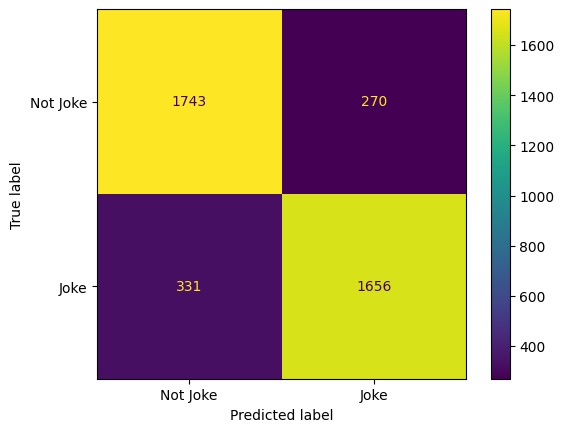

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Joke", "Joke"])
disp.plot()

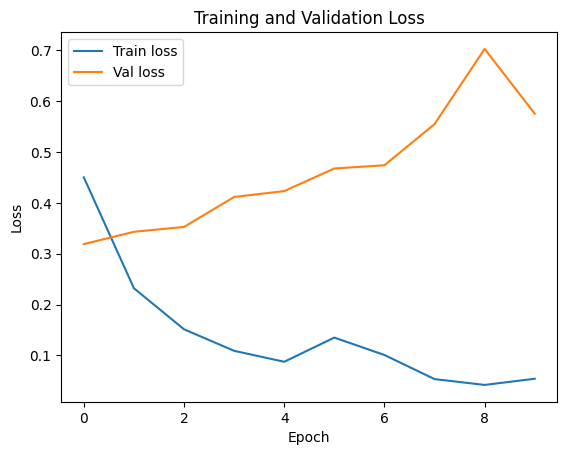

In [ ]:
# Plot training and validation loss history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label='Train loss')
plt.plot(val_loss, label='Val loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Model #12: Naive Bayes

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

# take a random sample of 500 rows
jokes_sampled = jokes_df.sample(n=20000, random_state=42)

# Split the data into training and testing sets
X = jokes_sampled['clean_joke'].to_numpy()
y = jokes_sampled['humor']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize the text data
vectorizer = CountVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# Train the Naive Bayes model
model = MultinomialNB()
model.fit(X_train_vect, y_train)


MultinomialNB()

In [ ]:
# Evaluate the model on the test set
y_pred_train = model.predict(X_train_vect)
y_pred_test = model.predict(X_test_vect)

In [ ]:
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Train Accuracy: 0.947
Test Accuracy: 0.8835


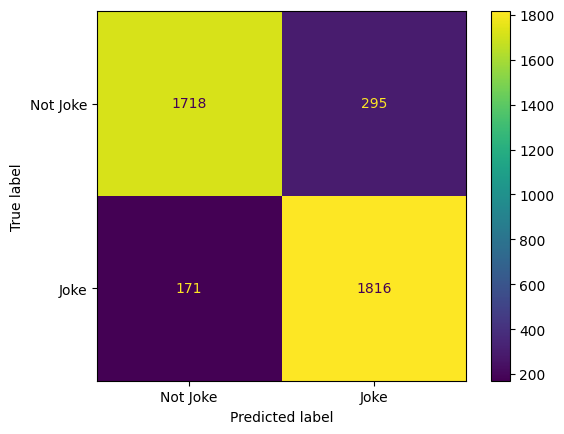

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Joke", "Joke"])
disp.plot()

In [ ]:
from sklearn.metrics import classification_report

# get classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

       False       0.91      0.85      0.88      2013
        True       0.86      0.91      0.89      1987

    accuracy                           0.88      4000
   macro avg       0.88      0.88      0.88      4000
weighted avg       0.89      0.88      0.88      4000



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# take a random sample of 500 rows
jokes_sampled = jokes_df.sample(n=20000, random_state=42)

# Split the data into training and testing sets
X = jokes_sampled['clean_joke'].to_numpy()
y = jokes_sampled['humor']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train_tfidf = vectorizer.fit_transform(X_train)

# Transform the testing data
X_test_tfidf = vectorizer.transform(X_test)

# Train the Naive Bayes model
model = MultinomialNB()
model.fit(X_train_tfidf, y_train)



MultinomialNB()

In [ ]:

# Evaluate the model on the test set
y_pred = model.predict(X_test_tfidf)

In [ ]:
train_accuracy = accuracy_score(y_train, model.predict(X_train_tfidf))
test_accuracy = accuracy_score(y_test, y_pred)

print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

Train Accuracy: 0.9479375
Test Accuracy: 0.87825


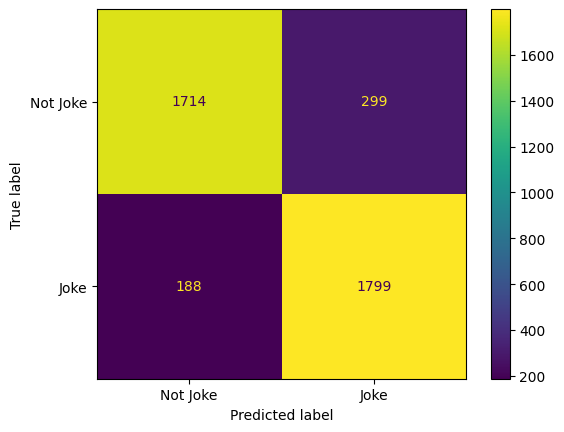

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Joke", "Joke"])
disp.plot()

In [ ]:
from sklearn.metrics import classification_report

# get classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

       False       0.90      0.85      0.88      2013
        True       0.86      0.91      0.88      1987

    accuracy                           0.88      4000
   macro avg       0.88      0.88      0.88      4000
weighted avg       0.88      0.88      0.88      4000



The best performing model is SVC using TFIDF vectorization so we will export a pkl file to run in streamlit app. This model will now be trained on the full dataset without test train split.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import nltk
from nltk.stem import WordNetLemmatizer

# Download NLTK data
nltk.download('punkt')
nltk.download('wordnet')

X = jokes_df['clean_joke']
y = jokes_df['humor']

# Define the pipeline
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('svc', SVC(C=1, kernel='linear'))
])

pipeline.fit(X,y)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Pipeline(steps=[('vectorizer', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('svc', SVC(C=1, kernel='linear'))])

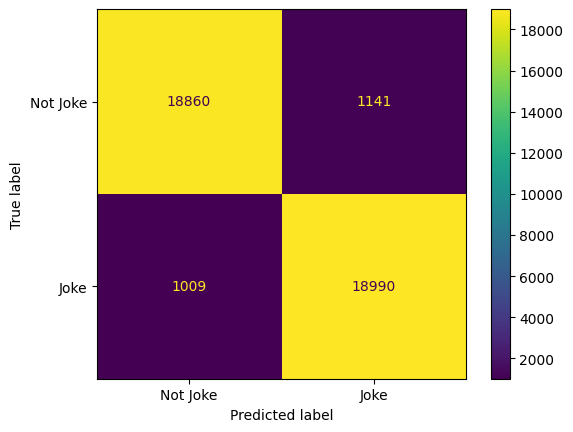

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Make predictions on the test data
y_pred = pipeline.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Joke", "Joke"])
disp.plot()

In [ ]:
# get classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

       False       0.95      0.94      0.95     20001
        True       0.94      0.95      0.95     19999

    accuracy                           0.95     40000
   macro avg       0.95      0.95      0.95     40000
weighted avg       0.95      0.95      0.95     40000



In [ ]:
import joblib

# save it as 'model.pkl' in the current working directory
joblib.dump(pipeline, 'model.pkl')